In [1]:
# Import useful python packages
import numpy as np

# Import packages to display images inline in the notebook
import matplotlib.pyplot as plt    
%matplotlib inline   

# Set general plotting options
params = {'legend.fontsize': '18', 'axes.labelsize': '18',
          'axes.titlesize': '18', 'xtick.labelsize': '18',
          'ytick.labelsize': '18', 'lines.linewidth': 2, 'axes.linewidth': 2, 'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# Import astropy packages 
from astropy import units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty
from astropy.io import fits # added by BAS on 8 April 2021
from astropy.utils.data import get_pkg_data_filename
from astropy.utils.data import download_file

# To find stars in the MRS spectralcubes and do aperture photometry
from photutils import DAOStarFinder, CircularAperture

# To deal with 1D spectrum
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion
from specutils import SpectrumList
from jdaviz import Specviz
from jdaviz import Cubeviz

# To fit a curve to the data
from scipy.optimize import curve_fit

# Display the video
from IPython.display import HTML, YouTubeVideo

In [3]:
# Save and Load Objects Using Pickle
import pickle


def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [4]:
def checkKey(dict, key):
      
    if key in dict.keys():
        print("Present, ", end=" ")
        print("value =", dict[key])
        return(True)
    else:
        print("Not present")
        return(False)

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
# Check if Pipeline 3 Reduced data exists and, if not, download it
import os
import urllib.request

if os.path.exists("combine_dithers_all_exposures_ch1-long_s3d.fits"):
    print("Pipeline 3 Data Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/reduced.tar.gz'
    urllib.request.urlretrieve(url, './reduced.tar.gz')
    # Unzip Tar Files

    import tarfile

    # Unzip files if they haven't already been unzipped
    if os.path.exists("reduced/"):
        print("Pipeline 3 Data Exists")
    else:
        tar = tarfile.open('./reduced.tar.gz', "r:gz")
        tar.extractall()
        tar.close()
        
    # Move Files 
    os.system('mv reduced/*fits .')

In [7]:
# Read in all X1D spectra to a single spectrum list and combine into a single spectrum1d object

ddd = '.'
splist = SpectrumList.read(ddd)

wlallorig = []
fnuallorig = []
dfnuallorig = []
for bndind in range(len(splist)):
    for wlind in range(len(splist[bndind].spectral_axis)):
        wlallorig.append(splist[bndind].spectral_axis[wlind].value)
        fnuallorig.append(splist[bndind].flux[wlind].value)
        dfnuallorig.append(splist[bndind].uncertainty[wlind].array)

wlallarr = np.array(wlallorig)
fnuallarr = np.array(fnuallorig)
dfnuallarr = np.array(dfnuallorig)
srtind = np.argsort(wlallarr)
wlall = wlallarr[srtind]
fnuall = fnuallarr[srtind]

# Developer Note: We put in errors of 0.0001, but uncertainties need to be fixed
dfnuall = (0.0001)*np.ones(len(fnuall))


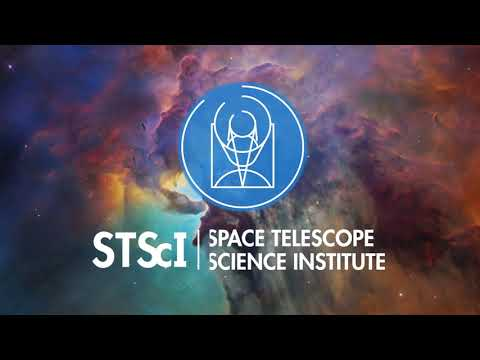

In [8]:
vid = YouTubeVideo("zLyRnfG32Bo")
display(vid)

In [9]:
# Open these spectra up in Specviz
specviz = Specviz()
specviz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [10]:
# Load in the spectrum list from above. 
specviz.load_spectrum(splist)

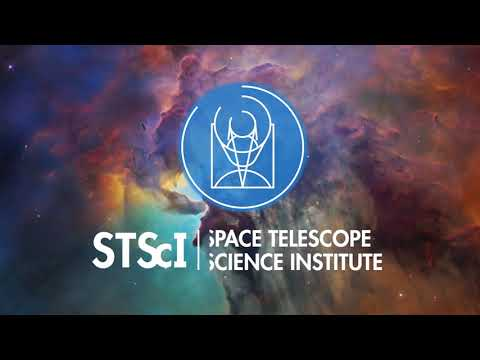

In [11]:
vid = YouTubeVideo("HMSYwiH3Gl4")
display(vid)

In [12]:
cubeviz = Cubeviz()
cubeviz.app

Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [13]:
# Here, we load the data into the Cubeviz app for visual inspection.  
# In this case, we're just looking at a single channel because, unlike Specviz, Cubeviz can only load a single cube at a time.

ch1short_cubefile = 'combine_dithers_all_exposures_ch1-long_s3d.fits'
cubeviz.load_data(ch1short_cubefile)

In [14]:
# Video showing the selection of the star with a circular region of interest
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/region_select.mov" frameborder="0" allowfullscreen></iframe>')

In [15]:
# Now extract spectrum from your spectral viewer
spec_agb = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 1') # AGB star only

In [16]:
wav = wlall*u.micron # Wavelength: microns
fl = fnuall*u.Jy # Fnu:  Jy
efl = dfnuall*u.Jy # Error flux: Jy

# Make a 1D spectrum object
spec = Spectrum1D(spectral_axis=wav, flux=fl, uncertainty=StdDevUncertainty(efl))

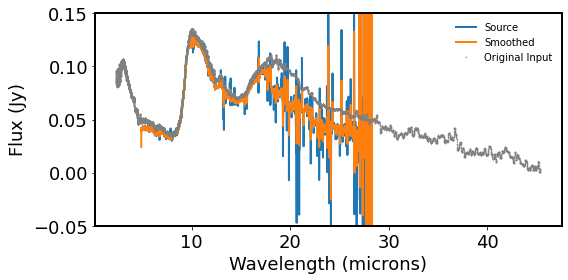

In [17]:
# Apply a 5 pixel boxcar smoothing to the spectrum
spec_bsmooth = box_smooth(spec, width=5)   

# Plot the spectrum & smoothed spectrum to inspect features 
plt.figure(figsize=(8, 4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')
plt.plot(spec.spectral_axis, spec_bsmooth.flux, label='Smoothed')
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.ylim(-0.05, 0.15)

# Overplot the original input spectrum for comparison
origspecfile = fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/63702662.txt', cache=False)
origdata = ascii.read(origspecfile)
wlorig = origdata['col1']
fnujyorig = origdata['col2']*0.001 # comes in as mJy, change to Jy to compare with pipeline output
plt.plot(wlorig, fnujyorig, '.', color='grey', markersize=1, label='Original Input')

plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

In [18]:
spec_agb = spec

In [19]:
# Open these spectra up in Specviz
specviz = Specviz()
specviz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [20]:
# For now, you must create your own spectrum1d object from your extracted cubeviz spectrum.  
flux = spec_agb.flux
wavelength = spec_agb.spectral_axis
spec1d = Spectrum1D(spectral_axis=wavelength, flux=flux)
specviz.load_spectrum(spec1d)

In [21]:
# Video showing how to smooth a spectrum in Specviz
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/smooth.mov" frameborder="0" allowfullscreen></iframe>')

In [22]:
# Video showing how to fit a blackbody 
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/blackbody_fit.mov" frameborder="0" allowfullscreen></iframe>')

In [23]:
spectra = specviz.get_spectra()
   
a = checkKey(spectra, "BB1")
if a is True:
    # Extract Blackbody fit from Specviz
    blackbody = spectra["BB1"]
if a is False:
    print("No Blackbody")
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/blackbody.fits', cache=False)
    blackbody = Spectrum1D.read(fn)

Not present
No Blackbody


In [24]:
# Delete any existing output in current directory
if os.path.exists("blackbody.fits"):
    os.remove("blackbody.fits")
else:
    print("The blackbody.fits file does not exist")

The blackbody.fits file does not exist


In [25]:
# Save if you so desire. Keep commented otherwise.
# blackbody.write('blackbody.fits')

In [26]:
# Rename blackbody.flux as ybest
ybest = blackbody.flux

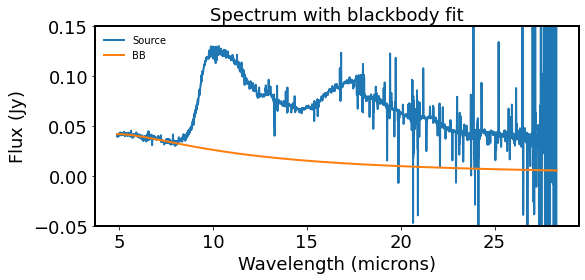

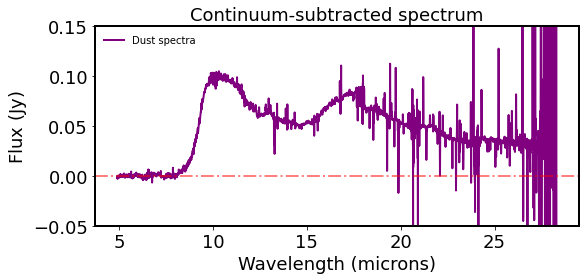

In [27]:
# Plot the spectrum & the model fit to the short wavelength region of the data.
plt.figure(figsize=(8, 4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')
plt.plot(spec.spectral_axis, ybest, label='BB')
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Spectrum with blackbody fit")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.ylim(-0.05, 0.15)
plt.show()
plt.close()

# Now subtract the BB and plot the underlying dust continuum
plt.figure(figsize=(8, 4))
plt.plot(spec.spectral_axis, spec.flux.value - ybest.value, color='purple', label='Dust spectra')
plt.axhline(0, color='r', linestyle='dashdot', alpha=0.5)
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum-subtracted spectrum")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.ylim(-0.05, 0.15)
plt.show()
plt.close()

In [28]:
# Subtract the continuum and plot in a new instance of specviz
bbsub_spectra = spec - ybest.value     # continuum subtracted spectra - Dust only

In [29]:
specviz = Specviz()
specviz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [30]:
specviz.load_spectrum(bbsub_spectra)

In [31]:
# Video showing how to fit a polynomial to two separate spectral regions within a single subset
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/poly_fit.mov" frameborder="0" allowfullscreen></iframe>')

In [32]:
spectra = specviz.get_spectra()
   
a = checkKey(spectra, "PolyFit")
if a is True:
    # Extract Blackbody fit from Specviz
    blackbody = spectra["PolyFit"]
if a is False:
    print("No Polyfit")
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/poly.fits', cache=False)
    poly = Spectrum1D.read(fn)

Not present
No Polyfit


In [33]:
# Delete any existing output in current directory
if os.path.exists("poly.fits"):
    os.remove("poly.fits")
else:
    print("The poly.fits file does not exist")

The poly.fits file does not exist


In [34]:
# Save if you so desire. Keep commented otherwise.
# poly.write('poly.fits')

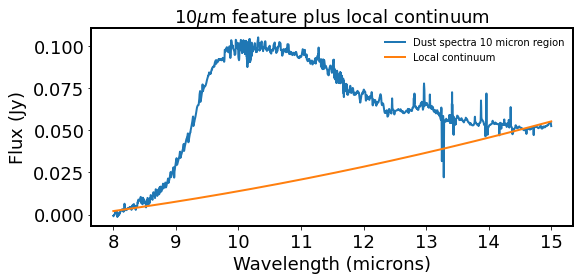

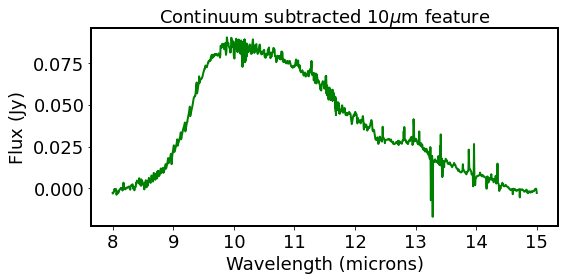

In [35]:
# Fit a local continuum between the flux densities at: 8.0 - 8.1 & 14.9 - 15.0 microns
# (i.e. excluding the line itself)

sw_region = 8.0   # lam0
sw_line = 8.1     # lam1
lw_line = 14.9    # lam2
lw_region = 15.0  # lam3

# Zoom in on the line complex & extract
line_reg_10 = SpectralRegion([(sw_region*u.um, lw_region*u.um)])
line_spec = extract_region(bbsub_spectra, line_reg_10)
polysub = extract_region(poly, line_reg_10)
line_y_continuum = polysub.flux

# -----------------------------------------------------------------
# Generate a continuum subtracted and continuum normalised spectra

line_spec_norm = Spectrum1D(spectral_axis=line_spec.spectral_axis, flux=line_spec.flux/line_y_continuum, uncertainty=StdDevUncertainty(np.zeros(len(line_spec.spectral_axis))))
line_spec_consub = Spectrum1D(spectral_axis=line_spec.spectral_axis, flux=line_spec.flux - line_y_continuum, uncertainty=StdDevUncertainty(np.zeros(len(line_spec.spectral_axis))))

# -----------------------------------------------------------------
# Plot the dust feature & continuum fit to the region

plt.figure(figsize=(8, 4))

plt.plot(line_spec.spectral_axis, line_spec.flux.value,
         label='Dust spectra 10 micron region')

plt.plot(line_spec.spectral_axis, line_y_continuum, label='Local continuum')

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("10$\mu$m feature plus local continuum")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

# -----------------------------------------------------------------
# Plot the continuum subtracted 10 micron feature

plt.figure(figsize=(8, 4))

plt.plot(line_spec.spectral_axis, line_spec_consub.flux, color='green',
         label='continuum subtracted')

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum subtracted 10$\mu$m feature")
plt.tight_layout()
plt.show()
plt.close()

In [36]:
# Load 10 um feature back into specviz and calculate the Line flux; Line Centroid; Equivalent width
specviz = Specviz()
specviz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [37]:
specviz.load_spectrum(line_spec_consub, data_label='Continuum Subtraction')
specviz.load_spectrum(line_spec_norm, data_label='Normalized')

In [38]:
# Video showing how to measure lines within specviz
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/line_analysis_plugin.mov" frameborder="0" allowfullscreen></iframe>')

In [39]:
# Alternative method to analyze the 10um line within the notebook. Calculate the Line flux; Line Centroid; Equivalent width

line_centroid = centroid(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))
line_flux_val = line_flux(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))

equivalent_width_val = equivalent_width(line_spec_norm)

# Hack to convert the line flux value into more conventional units
# Necessary as spectra has mixed units: f_nu+lambda
line_flux_val = (line_flux_val * u.micron).to(u.W * u.m**-2 * u.micron,
                                              u.spectral_density(line_centroid)) / u.micron

print("Line_centroid: {:.6} ".format(line_centroid))
print("Integrated line_flux: {:.6} ".format(line_flux_val))
print("Equivalent width: {:.6} ".format(equivalent_width_val))

Line_centroid: 10.7569 micron 
Integrated line_flux: 6.65227e-15 W / m2 
Equivalent width: -15.0066 micron 


In [40]:
# Compute the optical depth of the 10 micron feature

tau = -(np.log(line_spec.flux.value / line_y_continuum.value))
optdepth_spec = Spectrum1D(spectral_axis=line_spec.spectral_axis,
                           flux=tau*(u.Jy/u.Jy))
        

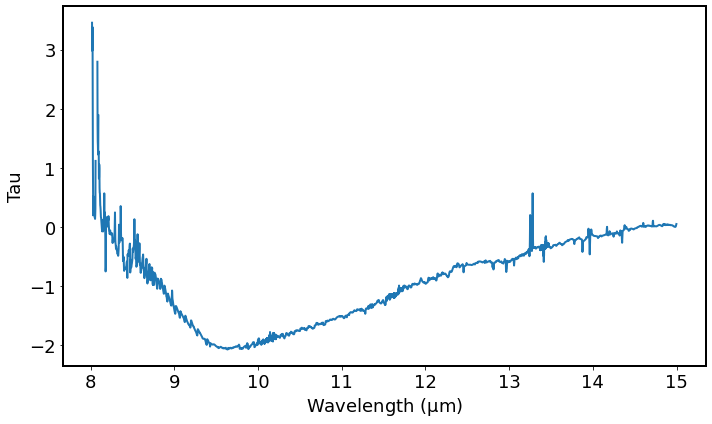

In [41]:
# Plot the optical depth of the 10 micron region vs wavelength
plt.figure(figsize=(10, 6))
plt.plot(optdepth_spec.spectral_axis, optdepth_spec.flux)
plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel('Tau') 
plt.tight_layout()
plt.show()
plt.close()